# v02001 Baseline

- [x] Baseline を見直す
    - 予測変数を対数変換しない。
    - モデルを poission から regression に変更する
- [x] WRMSSE の評価関数クラスを定義し、評価を行う。
- [x] Competition Evaluation と Training Evaluation を用意したい。
    - 学習では柔軟度が高く、使いやすい関数を良いしたい。
    - 評価では、できるだけLBと近い値で評価したい。
- [x] WRMSSE の評価関数クラスを定義し、LightGBM の評価関数として使う
- [x] 損失関数にRMSLEを適応してみる。
    - `lr=0.1` では学習率が大きすぎた。（対数変換をした評価が見られていないのでスコアが上昇するのか未確認）
- [ ] poisson 回帰を試す。
    - Local CV 0.55645 -> 0.52480 に変化した。
- [ ] 特徴量の追加
    -  https://www.kaggle.com/rohitsingh9990/m5-lgbm-fe?scriptVersionId=30700291
    - コスト関数を変えれば`0.55690`まで上がるらしい。
    - 特徴量のcacheは、どの特徴量がどのような影響があるのかを実験するために、役割ごとで分けて作ったほうがよさそう。
- [ ] Group K fold で学習してみる。
    - https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv
- [ ] Cut off lags nan rows
- [ ] カテゴリごとの標準化でスコアが改善するか試す
- [ ] 特徴量の追加、Aggregated Sales Feature

In [1]:
SEED = 42
VERSION = 'v02001'
TARGET = 'sales'

## Import Libraries

In [2]:
import os
import gc
import re
import json
import pickle
import datetime
from tqdm import tqdm
from typing import Union

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from typing import Union

import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from scipy.stats import linregress

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb

In [3]:
%load_ext autoreload
%autoreload 2
# custom funcs
from script import WRMSSEEvaluator
from script import cache_result
from script import reduce_mem_usage
from script import load_pickle, dump_pickle

## Load Data And Initial Processing

In [4]:
@cache_result(filename='parse_calendar', use_cache=True)
def parse_calendar():
    calendar = pd.read_pickle('../data/reduced/calendar.pkl')
    # fill null feature
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for f in nan_features:
        calendar[f].fillna('null', inplace=True)
    # label encoding
    cat_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for f in cat_features:
        encodaer = preprocessing.LabelEncoder()
        calendar[f] = encodaer.fit_transform(calendar[f])

    calendar['date'] = pd.to_datetime(calendar['date'])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "weekofyear",
        "day",
        "dayofweek",
        "is_year_end",
        "is_year_start",
        "is_quarter_end",
        "is_quarter_start",
        "is_month_end",
        "is_month_start",
    ]

    for attr in attrs:
        calendar[attr] = getattr(calendar['date'].dt, attr)
    calendar["is_weekend"] = calendar["dayofweek"].isin([5, 6]).astype(np.int8)

    # drop_features = ['weekday', 'wday', 'month', 'year']
    # features = calendar.columns.tolist()
    # features = [f for f in features if f not in drop_features]
    return calendar
 

_ = parse_calendar()

Load Cached data, features/parse_calendar.pkl


In [5]:
@cache_result(filename='parse_sell_prices', use_cache=True)
def parse_sell_prices():
    sell_prices = pd.read_pickle('../data/reduced/sell_prices.pkl')
    return sell_prices

_ = parse_sell_prices()

Load Cached data, features/parse_sell_prices.pkl


In [6]:
@cache_result(filename='parse_sales_train', use_cache=True)
def parse_sales_train():
    train = pd.read_pickle('../data/reduced/sales_train_validation.pkl')
    # Add Prediction Columns
    start_d = 1914
    end_d = 1969
    for i in range(start_d, end_d+1):
        train[f'd_{i}'] = 0
    return train

_ = parse_sales_train()

Load Cached data, features/parse_sales_train.pkl


## Transform

In [7]:
@cache_result(filename='melted_and_merged_train', use_cache=True)
def melted_and_merged_train():
    # Load Data
    calendar = pd.read_pickle('features/parse_calendar.pkl')
    sell_prices = pd.read_pickle('features/parse_sell_prices.pkl')
    df = pd.read_pickle('features/parse_sales_train.pkl')

    idx_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    df = pd.melt(df, id_vars=idx_cols, var_name='d', value_name='sales')
    df = pd.merge(df, calendar, how='left', on='d')
    df = pd.merge(df, sell_prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

    # Label Encoding
    label_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    for c in label_cols:
        encodaer = preprocessing.LabelEncoder()
        df[c] = encodaer.fit_transform(df[c])

    cat_cols = [
        'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
        'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
        'quarter', 'month', 'week', 'day', 'dayofweek', 'weekofyear'
    ]
    for c in cat_cols:
        df[c] = df[c].astype('category')

    df.dropna(subset=['sell_price'], axis=0, inplace=True)
    return df.pipe(reduce_mem_usage)

_ = melted_and_merged_train()

Load Cached data, features/melted_and_merged_train.pkl


## Feature Engineering

In [8]:
@cache_result(filename='simple_fe', use_cache=True)
def simple_fe():
    df = pd.read_pickle('features/melted_and_merged_train.pkl')
    # rolling demand features
    df['sales_lag_t28'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28))
    df['sales_lag_t29'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(29))
    df['sales_lag_t30'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(30))
    df['sales_rolling_mean_t7'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['sales_rolling_std_t7'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(7).std())
    df['sales_rolling_mean_t30'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['sales_rolling_mean_t90'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['sales_rolling_mean_t180'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['sales_rolling_std_t30'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).std())
    df['sales_rolling_skew_t30'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).skew())
    df['sales_rolling_kurt_t30'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).kurt())
    
    # price features
    df['price_lag_t1'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1)) # after drop.
    df['price_change_t1'] = (df['price_lag_t1'] - df['sell_price']) / (df['price_lag_t1'])
    df['rolling_price_max_t365'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max()) # after drop.
    df['price_change_t365'] = (df['rolling_price_max_t365'] - df['sell_price']) / (df['rolling_price_max_t365'])
    df['price_rolling_std_t7'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    df['price_rolling_std_t30'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    df.drop(['rolling_price_max_t365', 'price_lag_t1'], inplace = True, axis = 1)
    
    return df.pipe(reduce_mem_usage)

In [9]:
train = simple_fe()

Load Cached data, features/simple_fe.pkl


In [10]:
print(train.shape)
train.head()

(47735397, 49)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,week,weekofyear,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,sell_price,sales_lag_t28,sales_lag_t29,sales_lag_t30,sales_rolling_mean_t7,sales_rolling_std_t7,sales_rolling_mean_t30,sales_rolling_mean_t90,sales_rolling_mean_t180,sales_rolling_std_t30,sales_rolling_skew_t30,sales_rolling_kurt_t30,price_change_t1,price_change_t365,price_rolling_std_t7,price_rolling_std_t30
7,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_1,12,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,1,4,4,29,5,False,False,False,False,False,False,1,0.459961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,d_1,2,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,1,4,4,29,5,False,False,False,False,False,False,1,1.559570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,HOBBIES_1_010_CA_1_validation,1446,3,1,0,0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,1,4,4,29,5,False,False,False,False,False,False,1,3.169922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,HOBBIES_1_012_CA_1_validation,1448,3,1,0,0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,1,4,4,29,5,False,False,False,False,False,False,1,5.980469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,d_1,4,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,1,4,4,29,5,False,False,False,False,False,False,1,0.700195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare Evaluation Object

In [11]:
''' Note.
- この関数の制約は
    - validation では, すべての id が存在し, 連続する28日のデータであること.
    - validation と prediction の id の順序が同一であること.
'''
class WRMSSEForLightGBM(WRMSSEEvaluator):
    def feval(self, preds, dtrain):
        row, col = self.valid_df[self.valid_target_columns].shape
        preds = preds.reshape(col, row).T
        
        score = self.score(preds)
        return 'WRMSSE', score, False
    
    def get_sample_weight(self, data_idx):
        '''
        sample weight for rmse.
        Weights for doing WRMSSE-like evaluations using RMSE.
        '''
        data_idx = data_idx.apply(lambda x: x.rsplit('_', 1)[0]).values
        
        weight_df = self.weights * 12
        weight_df.index = weight_df.index.str.replace('--', '_')
        weight_df.columns = ['weight']
        scale = np.where(self.scale != 0, self.scale, 1)
        weight_df['sample_weight'] = weight_df['weight'] / scale

        return weight_df.loc[data_idx, 'sample_weight'].values


    
@cache_result(filename='evaluator', use_cache=False)
def get_evaluator():
    train_df = pd.read_pickle('../data/reduced/sales_train_validation.pkl')

    train_fold_df = train_df.iloc[:, :-28]
    valid_fold_df = train_df.iloc[:, -28:].copy()

    evaluator = WRMSSEForLightGBM(
        train_df=train_fold_df, 
        valid_df=valid_fold_df, 
        calendar=pd.read_pickle('../data/reduced/calendar.pkl'), 
        prices=pd.read_pickle('../data/reduced/sell_prices.pkl')
    )
    
    return evaluator
    
evaluator = get_evaluator()

Cache to features/evaluator.pkl


## Train Model

In [12]:
# ''' Split Data '''
# def train_eval_submit_split(df, eval_days=28):
#     submit_mask = (df["date"] >= '2016-04-25')

#     eval_date = datetime.datetime.strptime('2016-04-25', '%Y-%m-%d') - datetime.timedelta(days=eval_days)
#     eval_mask = ((df["date"] >= eval_date) & (df["date"] < '2016-04-25'))
    
#     valid_date = datetime.datetime.strptime('2016-04-25', '%Y-%m-%d') - datetime.timedelta(days=eval_days*4)
#     valid_mask = ((df["date"] >= valid_date) & (df["date"] < '2016-04-25'))
    
#     train_mask = ((~eval_mask) & (~submit_mask) & (~valid_mask))
#     return df[train_mask], df[valid_mask], df[eval_mask], df[submit_mask]


''' Split Data '''
def train_eval_submit_split(df, eval_days=28):
    oldest_submit_date = '2016-04-25'
    submit_mask = (df["date"] >= oldest_submit_date)

    eval_date = datetime.datetime.strptime(oldest_submit_date, '%Y-%m-%d') - datetime.timedelta(days=eval_days)
    eval_mask = ((df["date"] >= eval_date) & (df["date"] < oldest_submit_date))
    
    train_mask = ((~eval_mask) & (~submit_mask))
    return df[train_mask], df[eval_mask], df[submit_mask]

In [13]:
# train_data, valid_data, eval_data, sub_data = train_eval_submit_split(train)

all_train_data, eval_data, sub_data = train_eval_submit_split(train)

In [14]:
train_data, valid_data = train_test_split(all_train_data, test_size=0.2, shuffle=False, random_state=SEED)

In [15]:
target = 'sales'
# features = [
#     'item_id',
#     'dept_id',
#     'cat_id',
#     'store_id',
#     'state_id',
#     'day',
#     'event_name_1',
#     'event_type_1',
#     'event_name_2',
#     'event_type_2',
#     'snap_CA',
#     'snap_TX',
#     'snap_WI',
#     'sell_price',
#     'sales_lag_t28',
#     'sales_lag_t29',
#     'sales_lag_t30',
#     'sales_rolling_mean_t7',
#     'sales_rolling_std_t7',
#     'sales_rolling_mean_t30',
#     'sales_rolling_mean_t90',
#     'sales_rolling_mean_t180',
#     'sales_rolling_std_t30',
#     'sales_rolling_skew_t30',
#     'sales_rolling_kurt_t30',
#     'price_change_t1',
#     'price_change_t365',
#     'price_rolling_std_t7',
#     'price_rolling_std_t30',
#     'year',
#     'month',
#     'week',
#     'dayofweek'
# ]

cols_to_drop = ['id', 'd', 'date', 'wm_yr_wk', 'weekday', 'year'] + [target]
features = train.columns.tolist()
features = [f for f in features if f not in cols_to_drop]
print(features)

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday', 'month', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'quarter', 'week', 'weekofyear', 'day', 'dayofweek', 'is_year_end', 'is_year_start', 'is_quarter_end', 'is_quarter_start', 'is_month_end', 'is_month_start', 'is_weekend', 'sell_price', 'sales_lag_t28', 'sales_lag_t29', 'sales_lag_t30', 'sales_rolling_mean_t7', 'sales_rolling_std_t7', 'sales_rolling_mean_t30', 'sales_rolling_mean_t90', 'sales_rolling_mean_t180', 'sales_rolling_std_t30', 'sales_rolling_skew_t30', 'sales_rolling_kurt_t30', 'price_change_t1', 'price_change_t365', 'price_rolling_std_t7', 'price_rolling_std_t30']


In [16]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': SEED,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 5, 
    'colsample_bytree': 0.75,
    'force_row_wise': True
}

train_params = {
    'num_boost_round': 2500, 
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
#     'feval': evaluator.feval
}

In [17]:
train_set = lgb.Dataset(train_data[features], train_data[target])
val_set = lgb.Dataset(valid_data[features], valid_data[target], reference=train_set)

use_weight = False
if use_weight:
    train_set.set_weight(evaluator.get_sample_weight(train_data['id']))
    val_set.set_weight(evaluator.get_sample_weight(valid_data['id']))

In [18]:
model = lgb.train(params, train_set, valid_sets=[train_set, val_set], **train_params)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.65077	valid_1's rmse: 2.30792
[200]	training's rmse: 2.58701	valid_1's rmse: 2.29462
[300]	training's rmse: 2.54876	valid_1's rmse: 2.2906
[400]	training's rmse: 2.51862	valid_1's rmse: 2.28913
[500]	training's rmse: 2.49363	valid_1's rmse: 2.28583
[600]	training's rmse: 2.47326	valid_1's rmse: 2.28502
[700]	training's rmse: 2.45469	valid_1's rmse: 2.28488
Early stopping, best iteration is:
[660]	training's rmse: 2.46247	valid_1's rmse: 2.28445


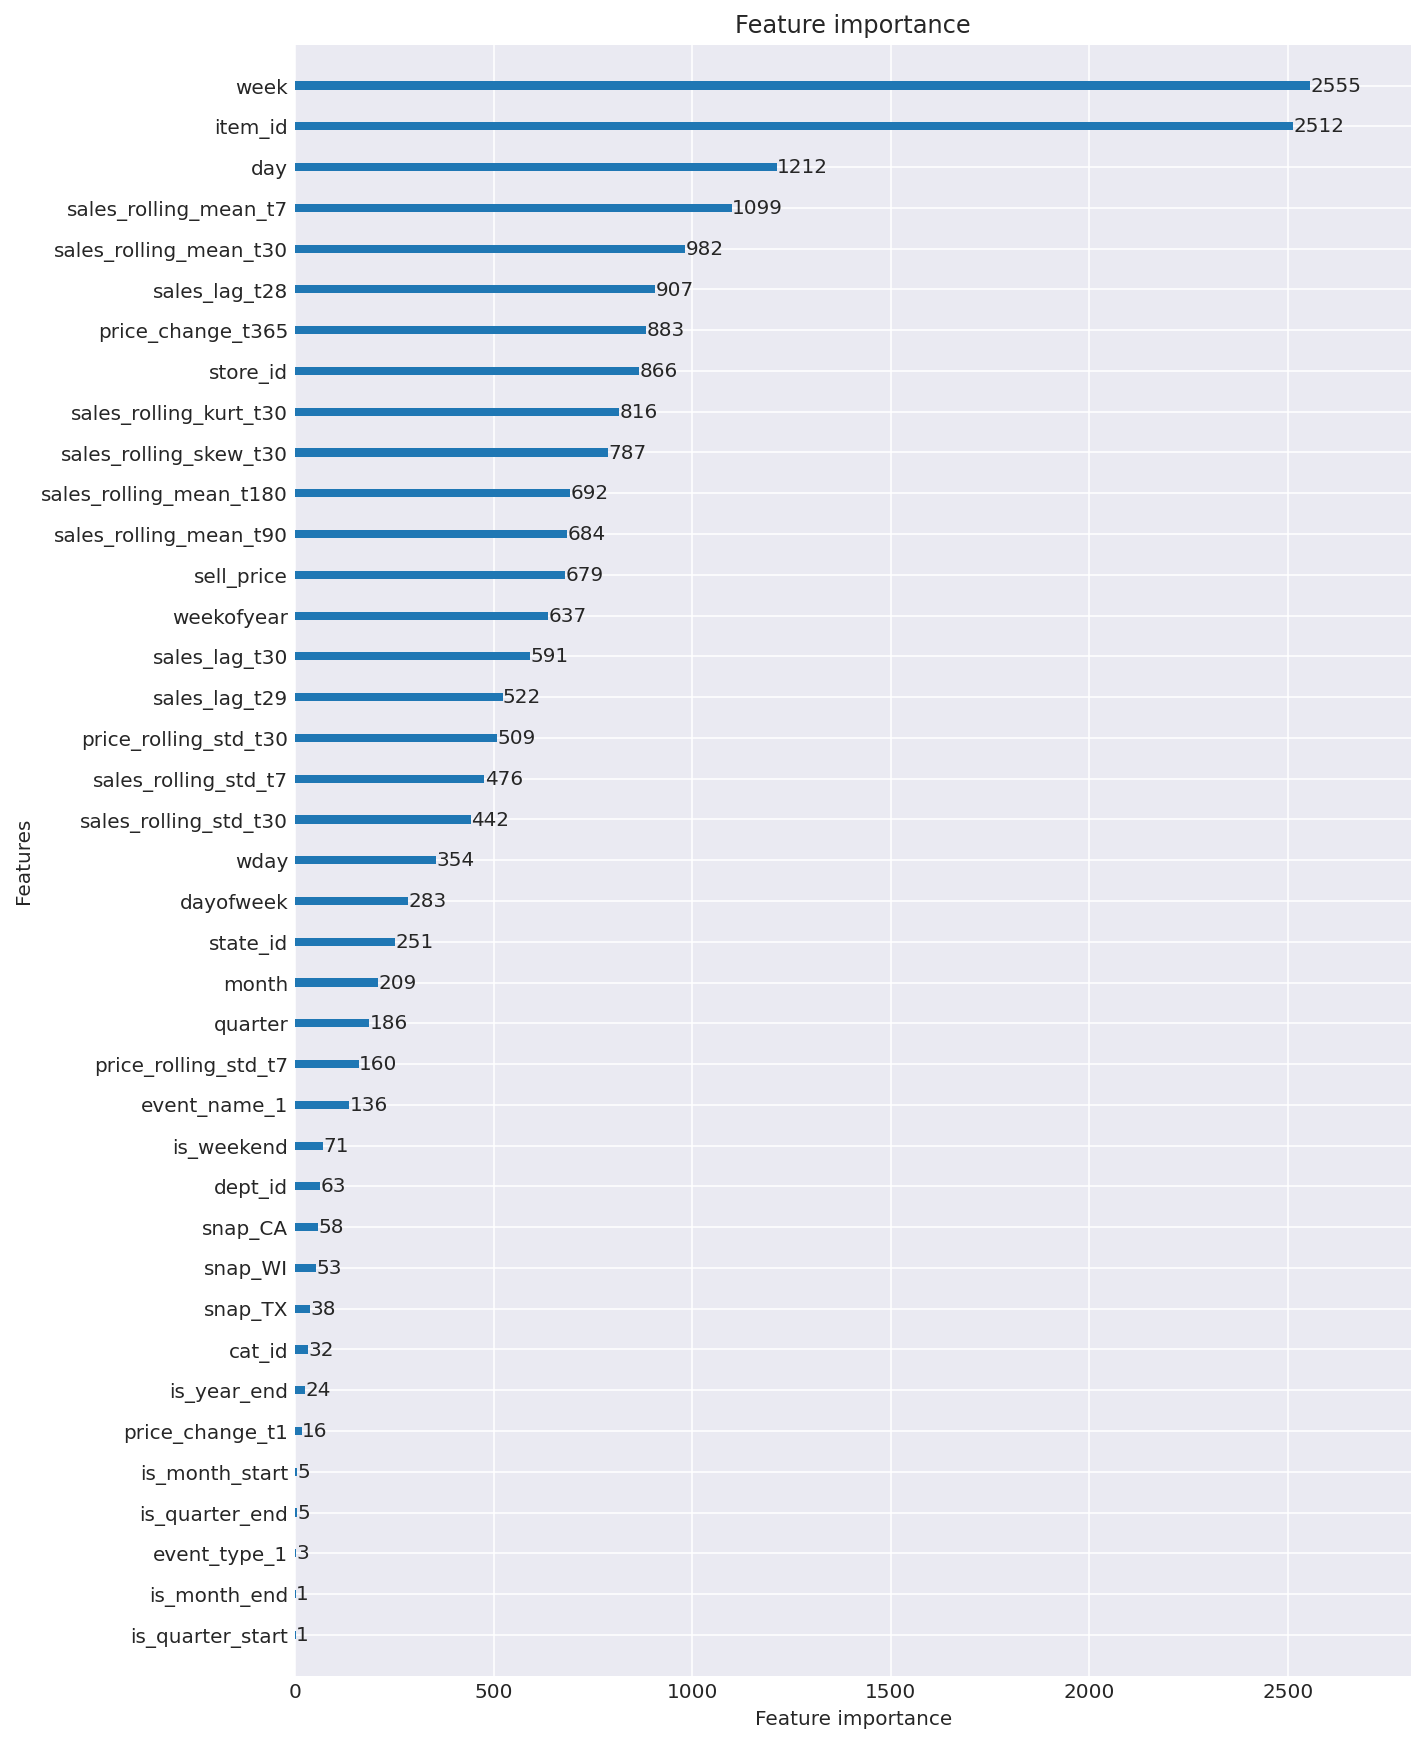

In [19]:
lgb.plot_importance(model, max_num_features=None, figsize=(10, 15))

## Evaluation

In [20]:
val_pred = model.predict(eval_data[features])
val_rmse = metrics.mean_squared_error(val_pred, eval_data[target], squared=False)
print(f'Our val RMSE score is {val_rmse}')

valid_preds = val_pred.reshape(28, -1).T
valid_wrmsse = evaluator.score(valid_preds)
print(f'Our val WRMSSE score is {valid_wrmsse}')

Our val RMSE score is 2.150708027298823
Our val WRMSSE score is 0.603094766667374


## Submission

In [ ]:
sub_pred = model.predict(sub_data[features])

submission = sub_data[['id', 'd']].copy(deep=True)
submission['sales'] = sub_pred
submission = pd.pivot(submission, index='id', columns='d', values='sales').reset_index()
# split valid and eval
valid_sub = submission[['id']+[f'd_{i}' for i in range(1914, 1942)]]
eval_sub = submission[['id']+[f'd_{i}' for i in range(1942, 1970)]]
# rename columns
valid_sub.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
eval_sub.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
# rename id evaluation
eval_sub = eval_sub.assign(id=lambda x: x['id'].str.replace('validation', 'evaluation'))

submission = pd.concat([valid_sub, eval_sub], axis=0)

sample_submission = pd.read_pickle('../data/reduced/sample_submission.pkl')
submission = sample_submission[['id']].merge(submission, how='left', on='id')
submission.to_csv(f'submit/{VERSION}_{valid_wrmsse:.05}.csv.gz', index=False, compression='gzip')

In [ ]:
print(submission.shape)
submission.head()